# BUSINESS CASE

The Objective of this project is to correctly identify digits from a dataset of tens of thousands of handwritten images. 

# DOMAIN ANALYSIS

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', 100)

In [2]:
#pip install tensorflow

#### DataSet:
MNIST ("Modified National Institute of Standards and Technology") is dataset includes handwritten digits total of 70,000 images consisting of 60,000 examples in training set and 10,000 examples in testing set, both with labeled images from 10 digits (0 to 9).    
Handwritten digits are images in the form of 28*28 gray scale intensities of images representing an image along with the first column to be a label (0 to 9) for every image. The same has opted for the case of the testing set as 10,000 images with a label of 0 to 9.   

The DataSet Contains:  
1. Pixels are arranged row-wise, ranging from 0 to 255, as from RGB color code.   
2. Background as white (0 value from RGB) and foreground as black (255 value from RGB).   
3. Labels of digits classified from 0 to 9.   

In [3]:
#Load and prepare the MNIST dataset.
import tensorflow as tf
from tensorflow.keras.datasets import mnist

2024-03-08 08:59:03.221254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [6]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


# Null Values

In [7]:
np.isnan(x_train).sum()

0

In [8]:
np.isnan(y_train).sum()

0

In [9]:
np.isnan(x_test).sum()

0

#### Insights:
There are no NaN values in our dataset. There is no need to preprocess the data to deal with Nan's.

# Normalization and Reshaping

### Rescale the Images by Dividing Every Pixel in Every Image by 255

In [10]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

#### Insights: 
The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by 255.0. This also converts the sample data from integers to floating-point numbers.

### Label Encoding : one hot encoder

In [11]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

#### Insights
The labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

# Visualize Data

#### Visualize the First 50 Training Images

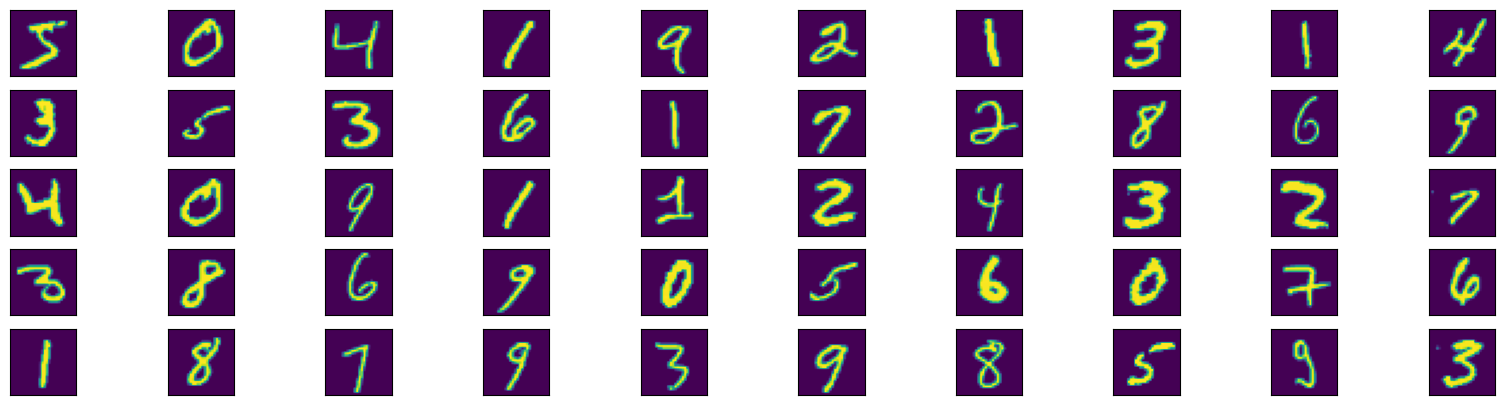

In [12]:
fig = plt.figure(figsize=(20,5))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


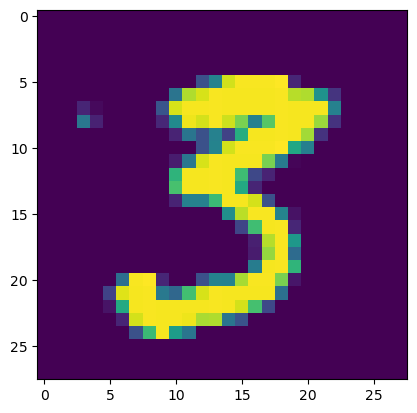

In [13]:
plt.imshow(x_train[49][:,:,0])
print(y_train[49])

#### Insights :
we tried to find the 50th image of a dataset.  
The image is an image of a handwritten 7. The one-hot encoding holds the value of 7

## Model 1: Convolutional Neural Network (CNN)

### Define The Model

In [14]:
batch_size = 64
num_classes = 10
epochs = 5

### Creating the Model

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

#### Insights :
Sequential is useful for stacking layers where each layer has one input tensor and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the Flatten, Dense, and Dropout layers.  

The model contains various layers stacked on top of each other. The output of one layer feeds into the input of the next layer.   

Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.   

MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.   

Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.      

relu is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.   

Flatten converts the tensors into a 1D vector.   

The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class (one for each digit).   



### Compile the Model

In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

#### Insights:
 this model aims to categorize the images, we will use a categorical_crossentropy loss function.

# Train & Fit the Model

### Callback Function

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

#### Insights:
The following cell defines a CallBack so that if 99.5% accuracy is achieved, the model stops training. The model is not likely to stop prematurely if only 5 epochs are specified.

### Fit the Training Data

Testing the model on a validation dataset prevents overfitting of the data. We specified a 10% validation and 90% training split.

In [20]:
cnn_model = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 165s 194ms/step - loss: 0.2076 - acc: 0.9354 - val_loss: 0.0430 - val_acc: 0.9867
Epoch 2/5
844/844 [==============================] - 210s 248ms/step - loss: 0.0700 - acc: 0.9794 - val_loss: 0.0360 - val_acc: 0.9902
Epoch 3/5
844/844 [==============================] - 172s 204ms/step - loss: 0.0575 - acc: 0.9833 - val_loss: 0.0361 - val_acc: 0.9908
Epoch 4/5
844/844 [==============================] - 158s 187ms/step - loss: 0.0495 - acc: 0.9859 - val_loss: 0.0361 - val_acc: 0.9917
Epoch 5/5
844/844 [==============================] - 164s 194ms/step - loss: 0.0446 - acc: 0.9869 - val_loss: 0.0308 - val_acc: 0.9922


#### Insights:
after fitting the model upto 5 Epochs, we can observe the increase in accuracy score.  
so if we increase the number of epochs, there is a chance of increase in High Accuracy

# Model Evaluation

In [21]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 7s - loss: 0.0200 - acc: 0.9939 - 7s/epoch - 21ms/step


[0.01998513750731945, 0.9939000010490417]

#### Insights:
The image classifier is now trained to 99.4% accuracy on the Testing Data. 

### Loss and Accuracy Curves

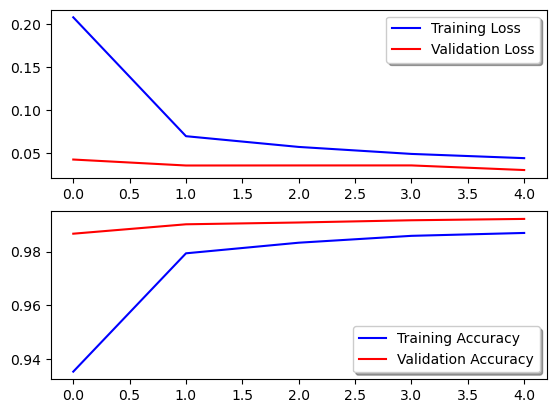

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(cnn_model.history['loss'], color='b', label="Training Loss")
ax[0].plot(cnn_model.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(cnn_model.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(cnn_model.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### Insights:
The accuracy increases over time and the loss decreases over time. However, the accuracy of our validation set seems to slightly decrease towards the end even thought our training accuracy increased. Running the model for more epochs might cause our model to be susceptible to overfitting.

# Predicting Results

### Confusion Matrix

In [25]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

313/313 [==============================] - 7s 22ms/step


<Axes: >

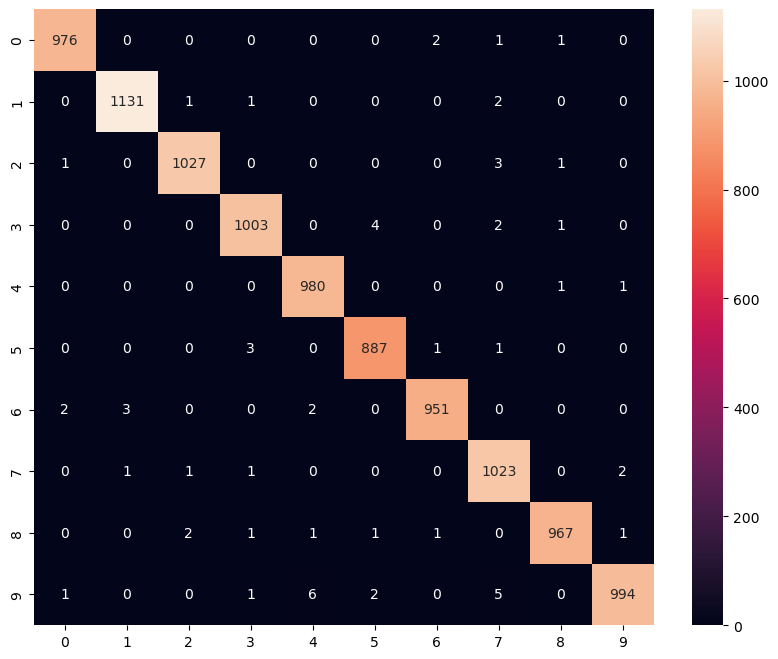

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

#### Insights:
There seems to be a slightly higher confusion between (0,6) and (4,9). This is reasonable as 0's and 6's look similar with their loops and 4's and 9's can be mistaken when the 4's are more rounded and 9's are more angular.

In [27]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Y_true, Y_pred_classes ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [28]:
cnn_acc = accuracy_score(Y_true, Y_pred_classes )
cnn_acc

0.9939

### Insights:
The confusion matrix shows that the classifier has correctly predicted the digits for an accuracy of 99.4% where there is very less missclassification.
Mostly 9, 7 & 1 has more missclaasifications comapared to other digits.
A high accuracy, precision, recall, and F1-score indicate that the model is performing well in classifying the data.

## Model 2 : Neural Networks (NN)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model

### Loading Data

In [30]:
from keras.datasets import mnist

# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [31]:
# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


#### Insights
In the above code, we displayed the class labels from 0-9 and the images trained for each class in train and test class

### Data visualization

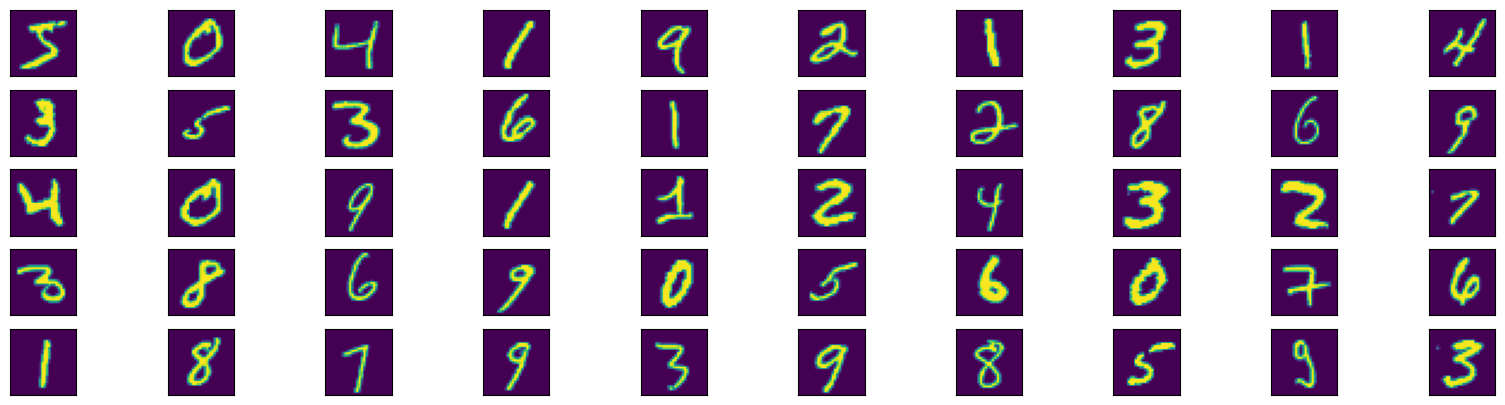

In [32]:
fig = plt.figure(figsize=(20,5))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### Compute the number of labels

In [33]:
# compute the number of labels
num_labels = len(np.unique(y_train))

### One-Hot Encoding
It converts each label into a one-hot vector as the labels are in digits format, 0 to 9.   

In [34]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Data Preprocessing

In [35]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [36]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

#### Insights:
The rest code computes the image dimensions, input_size of the first Dense layer and scales each pixel value from 0 to 255 to range from 0.0 to 1.0. Although raw pixel values can be used directly, it is better to normalize the input data as to avoid large gradient values that could make training difficult.   

The output of the network is also normalized. After training, there is an option to put everything back to the integer pixel values by multiplying the output tensor by 255.   

The proposed model is based on MLP layers. Therefore, the input is expected to be a 1D tensor. So, x_train and x_test are reshaped to [60000, 28 28] and [10000, 28 28], respectively.    

### Define The Model

In [37]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

#### Insights:
The batch_size argument indicates the number of data that we will use for each update of the model parameters.  

Hidden_units shows the number of hidden units.  

Dropout is the dropout rate (more on this in section 7 - Overfitting and Regularization).  

### Creating The Model

#### Explanation:
In Keras, an MLP layer is referred to as Dense, which stands for the densely connected layer.  

Both the first and second MLP layers are identical in nature with 256 units each, followed by relu activation and dropout.  

256 units are chosen since 128, 512 and 1,024 units have lower performance metrics. At 128 units, the network converges quickly, but has a lower test accuracy. The added number units for 512 or 1,024 does not increase the test accuracy significantly.   

The main data structure in Keras is the Sequential class, which allows the creation of a basic neural network. 

The problem is that the MNIST digit classification is inherently a non-linear process. Inserting a relu activation between Dense layers will enable MLPs to model non-linear mappings.   

relu or Rectified Linear Unit (ReLU) is a simple non-linear function. It allows positive inputs to pass through unchanged while clamping everything else to zero.   

In [38]:
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

#### Insights:
The above listing shows the model summary of the proposed network. It requires a total of 269,322 parameters.   

This is substantial considering that we have a simple task of classifying MNIST digits. So, MLPs are not parameter efficient.   

The total number of parameters required can be computed as follows:   

From input to Dense layer: 784 × 256 + 256 = 200,960.   

From first Dense to second Dense: 256 × 256 + 256 = 65,792.   

From second Dense to the output layer: 10 × 256 + 10 = 2,570.   

The total is 200,690 + 65,972 + 2,570 = 269,322   

### Compile the model

In [39]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### Fit the Model

In [40]:
nn_model = model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.4279 - accuracy: 0.8690
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1965 - accuracy: 0.9421
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1528 - accuracy: 0.9546
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1296 - accuracy: 0.9615
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1135 - accuracy: 0.9651
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1036 - accuracy: 0.9684
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0934 - accuracy: 0.9711
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0866 - accuracy: 0.9732
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0828 - accuracy: 0.9743
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0761 - accuracy: 0.9758

### Model Evaluation

In [41]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print(acc)
print(loss)

79/79 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.9827
0.982699990272522
0.06226610764861107


#### Insights:
The image classifier is now trained to 98.3% accuracy on the Testing Data.

### Loss and Accuracy Curves

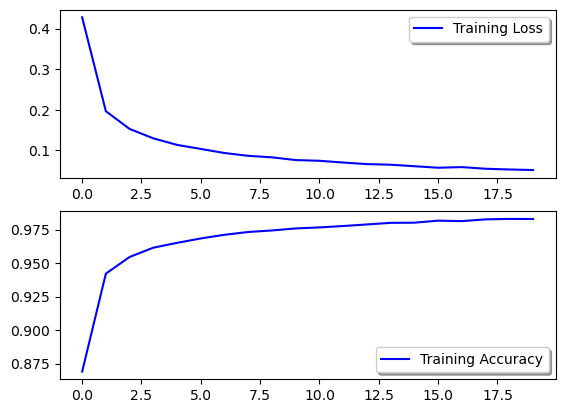

In [44]:
fig, ax = plt.subplots(2,1)
ax[0].plot(nn_model.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(nn_model.history['accuracy'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### Insights:
The accuracy increases over time and the loss decreases over time.

# Predicting Results

### Confusion Matrix

In [45]:
# Predict the values from the testing dataset
Y_pred_nn = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred_nn,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

313/313 [==============================] - 0s 1ms/step


<Axes: >

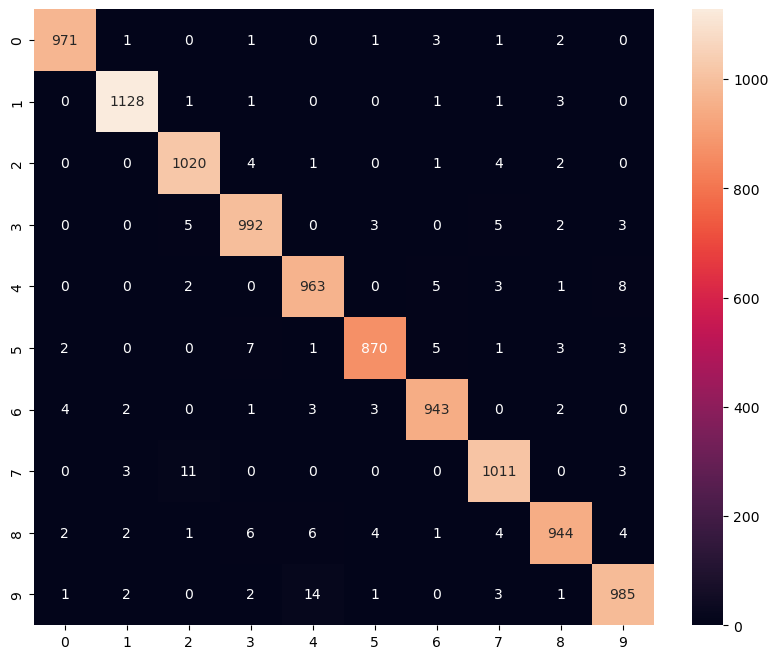

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

#### Insights:
There seems to be a slightly higher confusion between (3,5,8) and (4,9). This is reasonable as 3's , 5's & 8's look similar with their loops and 4's and 9's can be mistaken when the 4's are more rounded and 9's are more angular.

In [47]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Y_true, Y_pred_classes ))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [48]:
nn_acc = accuracy_score(Y_true, Y_pred_classes )
nn_acc

0.9827

### Insights:
The confusion matrix shows that the classifier has correctly predicted the digits for an accuracy of 98% where there is very less missclassification.
Mostly 3, 5& 8 has more missclaasifications comapared to other digits.
A high accuracy, precision, recall, and F1-score indicate that the model is performing well in classifying the data.

## Model 3 : K Nearest neighbour(KNN)

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [50]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [51]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [52]:
# compute the number of labels
num_labels = len(np.unique(y_train))

### One-Hot Encoding
It converts each label into a one-hot vector as the labels are in digits format, 0 to 9.   

In [53]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Data Preprocessing

In [54]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [55]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

#### Insights:
The rest code computes the image dimensions, input_size of the first Dense layer and scales each pixel value from 0 to 255 to range from 0.0 to 1.0. Although raw pixel values can be used directly, it is better to normalize the input data as to avoid large gradient values that could make training difficult.   

The output of the network is also normalized. After training, there is an option to put everything back to the integer pixel values by multiplying the output tensor by 255.   

The proposed model is based on MLP layers. Therefore, the input is expected to be a 1D tensor. So, x_train and x_test are reshaped to [60000, 28 28] and [10000, 28 28], respectively.    

In [56]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=4)

In [57]:
KNN.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [58]:
knn_prediction = KNN.predict(x_test)
knn_prediction

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
from sklearn import metrics
knn_acc = metrics.accuracy_score(y_test, knn_prediction)
knn_acc

0.9571

In [60]:
print(classification_report(y_test, knn_prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.99      0.95      0.97      1032
           3       0.98      0.95      0.97      1010
           4       0.99      0.94      0.96       982
           5       0.98      0.95      0.97       892
           6       0.99      0.98      0.99       958
           7       0.97      0.95      0.96      1028
           8       1.00      0.91      0.95       974
           9       0.98      0.94      0.96      1009

   micro avg       0.98      0.96      0.97     10000
   macro avg       0.98      0.96      0.97     10000
weighted avg       0.98      0.96      0.97     10000
 samples avg       0.96      0.96      0.96     10000



#### Insights:
In the KNN model we can observe that, the missclassification is more for many classes between 0-9.  
The accuracy score for this model is 95.8%

### Confusion Matrix

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(knn_prediction).argmax(axis=1))

<Axes: >

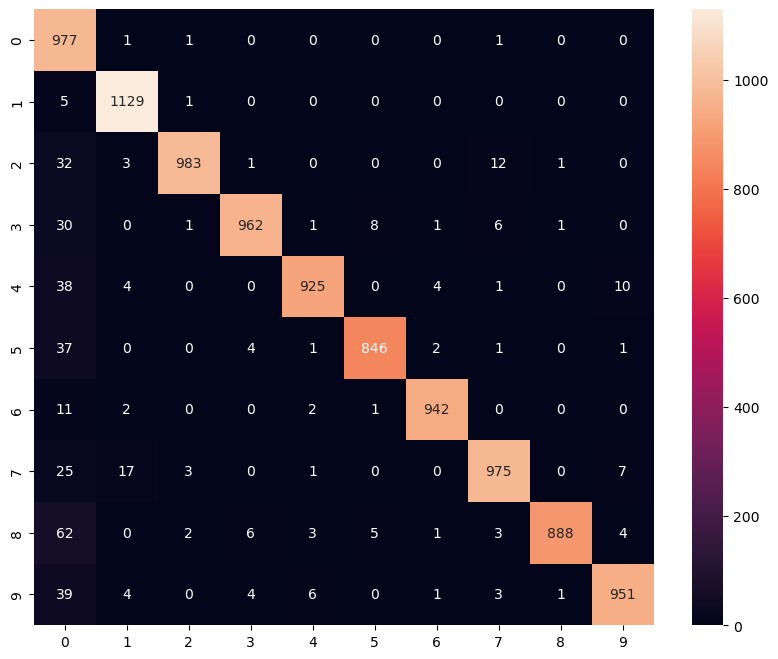

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')

#### Insights:
In KNN model, There is most of the missclassifications happened with only an accuracy of 95%.  
mostly 0 is missclassified in every class with highest Number. also, we can observe that 2 misclassified as 7 & 4 as 9.

## Model 4 : Support Vector Machine(SVM)

### 4.1 SVM with LinearSVC (i.e : linear kernel)

In [85]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [86]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [87]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [88]:
# compute the number of labels
num_labels = len(np.unique(y_train))
num_labels

10

### Data Preprocessing

In [89]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [90]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [91]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [92]:
print(x_test.shape, y_test.shape)

(10000, 784) (10000,)


#### Insights  :
for Linear SVC, the y_train should be less than 2d and we dont perform one hot encoding for that

In [93]:
from sklearn.svm import LinearSVC 
svm = LinearSVC(dual=False)
svm.fit(x_train, y_train)

LinearSVC(dual=False)

In [94]:
svc_prediction = svm.predict(x_test)
svc_prediction

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [100]:
svm.coef_
svm.intercept_

array([-1.20781794, -0.13507895, -0.81847737, -1.19360962, -0.50967898,
        0.03588734, -1.15067159, -0.2417391 , -2.08536401, -1.32436566])

In [95]:
from sklearn import metrics
svc_acc = metrics.accuracy_score(y_test, svc_prediction)
svc_acc

0.9183

#### Insights:
for LinearSVC, the accuracy score is only 91.8% 

In [96]:
print(classification_report(y_test, svc_prediction))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.87      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



#### Insights:
In the LinearSVC model we can observe that, the missclassification is more for many classes between 0-9.  
The accuracy score for this model is 92%

### Confusion Matrix

In [98]:
from sklearn.metrics import confusion_matrix
svc_cm = confusion_matrix(y_test, svc_prediction)

<Axes: >

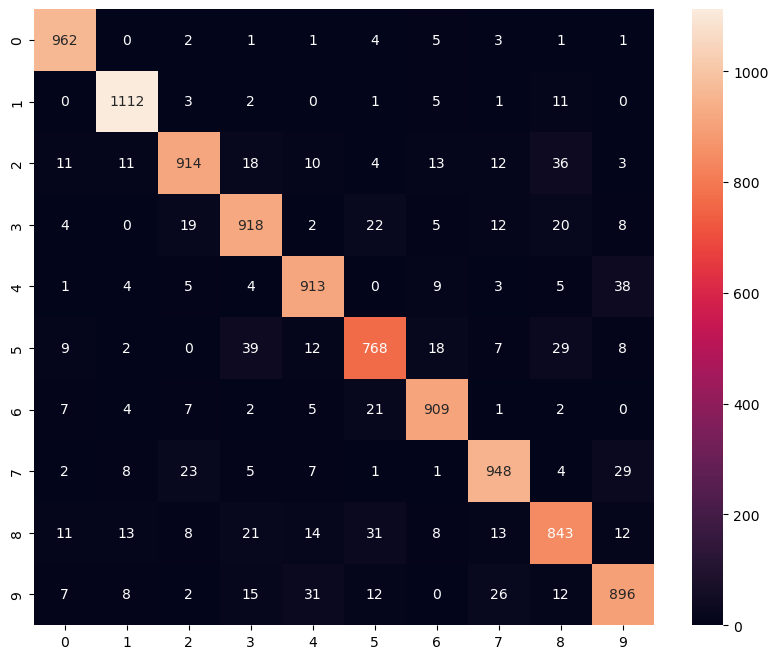

In [99]:
plt.figure(figsize=(10, 8))
sns.heatmap(svc_cm, annot=True, fmt='g')

#### Insights:
In LinearSVC model, There is most of the missclassifications happened with only an accuracy of 92%.  
mostly 7-9 is missclassified in every class with highest Number. also, we can observe that 2 misclassified as 8 & 3 as 5.

### 4.2 Non-Linear SVM  with the RBF kernel

In [105]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [106]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [107]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [108]:
# compute the number of labels
num_labels = len(np.unique(y_train))
num_labels

10

### Data Preprocessing

In [109]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [110]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [111]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [112]:
print(x_test.shape, y_test.shape)

(10000, 784) (10000,)


#### Insights  :
for non Linear SVC, the y_train should be less than 2d and we dont perform one hot encoding for that

In [118]:
# rbf kernel with other hyperparameters kept to default 
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(x_train, y_train)

SVC()

In [120]:
svcRBF_prediction = svm_rbf.predict(x_test)
svcRBF_prediction

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [123]:
from sklearn import metrics
svcRBF_acc = metrics.accuracy_score(y_test, svcRBF_prediction)
svcRBF_acc

0.9792

#### Insights:
for non LinearSVC, the accuracy score is only 97.9%.  
The accuracy achieved with a non-linear kernel is very higher than a linear one.

In [124]:
print(classification_report(y_test, svcRBF_prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



#### Insights:
In the LinearSVC model we can observe that, the missclassification is slightly less for many classes between 0-9.  
The accuracy score for this model is 98%

### Confusion Matrix

In [125]:
from sklearn.metrics import confusion_matrix
svcRBF_cm = confusion_matrix(y_test, svcRBF_prediction)

<Axes: >

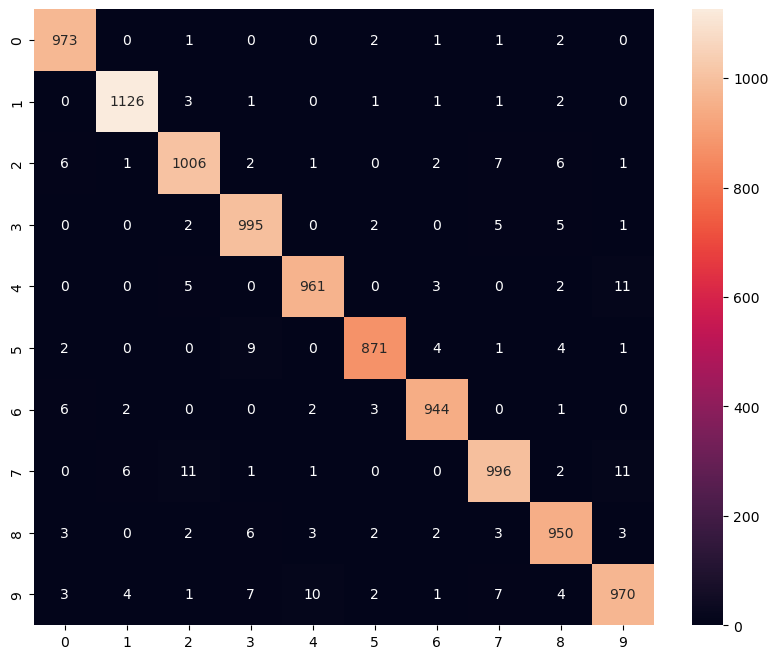

In [126]:
plt.figure(figsize=(10, 8))
sns.heatmap(svcRBF_cm, annot=True, fmt='g')

#### Insights:
In non LinearSVC model, There is very less missclassifications happened with an accuracy of 98%.  
most of the times 9 missclassified as 4 & 7 

# MODEL COMPARISION

In [130]:
model_names = ['CNN','NN','KNN','SVM','SVM_RBF']
accuracies = [cnn_acc, nn_acc, knn_acc, svc_acc, svcRBF_acc]

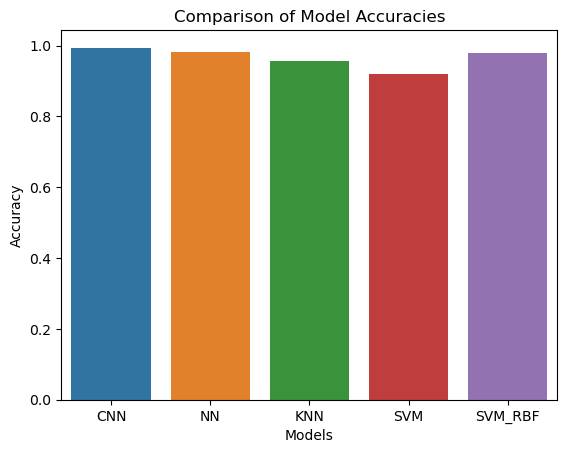

In [133]:
#Visualising the Model Accuracies

sns.barplot(x=model_names, y=accuracies )
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

In [134]:
print("Accuracy Score for Convolutional Neural Network (CNN) Model : ",cnn_acc)
print("Accuracy Score for Neural Network (NN) Model : ",nn_acc)
print("Accuracy Score for K - Nearest Neighbors Model : ",knn_acc)
print("Accuracy Score for Linear Support Vector Machines Model : ",svc_acc)
print("Accuracy Score for Non-Linear Support Vector Machines Model : ",svcRBF_acc)

Accuracy Score for Convolutional Neural Network (CNN) Model :  0.9939
Accuracy Score for Neural Network (NN) Model :  0.9827
Accuracy Score for K - Nearest Neighbors Model :  0.9571
Accuracy Score for Linear Support Vector Machines Model :  0.9183
Accuracy Score for Non-Linear Support Vector Machines Model :  0.9792


#### Insights: 
From all the models above we can observe that CNN gives better accuracy score

### Confusion matrix for CNN Model

In [136]:
#Confusion matrix for CNN model
print(confusion_mtx)

tf.Tensor(
[[ 971    1    0    1    0    1    3    1    2    0]
 [   0 1128    1    1    0    0    1    1    3    0]
 [   0    0 1020    4    1    0    1    4    2    0]
 [   0    0    5  992    0    3    0    5    2    3]
 [   0    0    2    0  963    0    5    3    1    8]
 [   2    0    0    7    1  870    5    1    3    3]
 [   4    2    0    1    3    3  943    0    2    0]
 [   0    3   11    0    0    0    0 1011    0    3]
 [   2    2    1    6    6    4    1    4  944    4]
 [   1    2    0    2   14    1    0    3    1  985]], shape=(10, 10), dtype=int32)


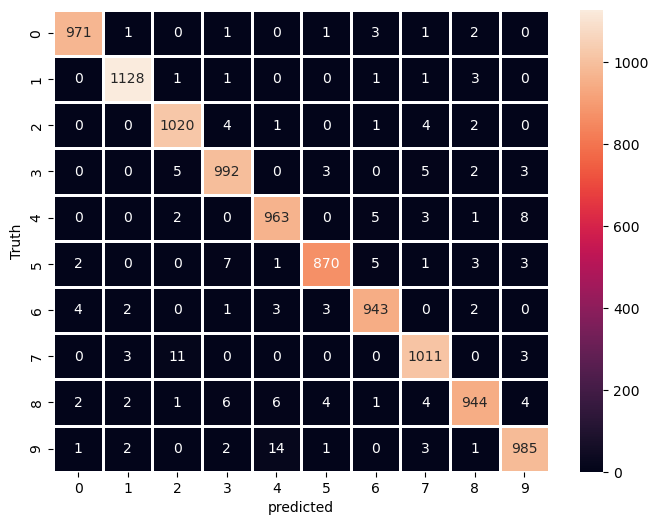

In [138]:
plt.figure(figsize= (8,6))
sns.heatmap(confusion_mtx, annot= True, linewidths= 2, linecolor= 'white', fmt='g')
plt.xlabel('predicted')
plt.ylabel('Truth')
plt.show()

# Conclusion

This information will aid in selecting the most suitable classifier for our specific task of Image Classification. This process contribute to the selection of a robust and accurate model for predicting Digits in the given dataset.From the results, it can be observed that CNN model demonstrates the highest accuracy & F1 score of 0.99 & 0.99. It also correctly classify the images with only very less missclassifications. Hence, it can be concluded that CNN emerges as the preferred model for our dataset.